In [1]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt 
%matplotlib inline

import random
seed = 666
random.seed(seed)

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr, spearmanr

import torch
from torch import optim
import torch.utils.data as utils
from torchvision import datasets
torch.manual_seed(seed)

from inv_vae.utils.helpers import Namespace, reset_weights, min_max_standardize, preprocess_neural_data
from inv_vae.models.vae import VAE
from inv_vae.models.inv_vae import INV_VAE

DEVICE = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(DEVICE)

cuda:0


In [2]:
SMALL_SIZE = 10
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE)    
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

In [3]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

from inv_vae.models.graph_conv import GraphConv
        

class VAE(nn.Module):
    '''
    graph auto-encoders. 
    ----
    inputs:
    
    ----
    outputs:
    
    '''
    def __init__(self, config): 
        super(VAE, self).__init__()
        self.n_nodes = config.n_nodes
        self.latent_dim = config.latent_dim
        self.hidden_dim = config.hidden_dim
        self.n_enc_layers = config.n_enc_layers
        self.n_dec_layers = config.n_dec_layers
        self.drop_out = config.drop_out
        self.beta=config.beta
        self.add_reg = config.add_reg
        self.y_dim = config.y_dim
        self.device = config.device
        
        # encoder layers (inference model)
        self.W = Variable(torch.randn(self.n_dec_layers, 1), requires_grad=True)  # add cuda() if gpu available
        self.b = Variable(torch.randn(self.latent_dim * self.latent_dim), requires_grad=True) # add cuda() if gpu available
        if 'cuda' in self.device.type:
            self.W = self.W.cuda()
            self.b = self.b.cuda()
        enc_layers = nn.ParameterList(
            [nn.Linear(self.latent_dim * self.latent_dim, self.hidden_dim) for i in range(self.n_enc_layers)]
        )
        self.enc_mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.enc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)
        self.enc_drop = nn.Dropout(p=self.drop_out) 
        self.encoder = nn.Sequential(*enc_layers)

        # decoder layers (generative model)        
        self.dec_layers = nn.ParameterList(
            [nn.Linear(self.latent_dim, self.n_nodes).to(self.device) for i in range(self.n_dec_layers)]
        )
        
        # graph convolution layers
        self.gc_layers = nn.ParameterList(
            [GraphConv(self.n_nodes, self.n_nodes, config.device).to(self.device) for i in range(self.n_dec_layers)]
        )
        
        self.fc = nn.Linear(self.n_nodes*self.n_nodes, self.n_nodes*self.n_nodes)
        
        if self.add_reg:
            self.reg = nn.Linear(self.latent_dim, self.y_dim)

    def encode(self, x_input):
        output = F.relu(self.encoder(x_input))
        output = self.enc_drop(output)
        return self.enc_mu(output), self.enc_logvar(output)

    def reparameterize(self, mu, logvar):
        sd = torch.exp(.5 * logvar)
        eps = torch.randn_like(sd)
        return mu + eps * sd

    def decode(self, z_input):
        dec_out = [torch.sigmoid(self.dec_layers[i](z_input)) for i in range(self.n_dec_layers)]    
        gc_out = [torch.sigmoid(self.gc_layers[i](dec_out[i])) for i in range(self.n_dec_layers)]     
        bmm_out = [torch.bmm(gc_out[i].unsqueeze(2), gc_out[i].unsqueeze(1)).view(-1, self.n_nodes*self.n_nodes, 1) \
                      for i in range(self.n_dec_layers)] 
        output = torch.cat(bmm_out, 2)
        output = torch.bmm(output, self.W.expand(output.shape[0], self.n_dec_layers, 1))
        output = output.view(-1, self.n_nodes*self.n_nodes) + self.b.expand(output.shape[0], self.n_nodes*self.n_nodes)
        output = torch.exp(self.fc(output))
        return output
            

    def forward(self, x_input):
        mu, logvar = self.encode(x_input.view(-1, self.n_nodes*self.n_nodes))
        z_sample = self.reparameterize(mu, logvar)
        x_output = self.decode(z_sample)
        if self.add_reg:
            y_output = self.reg(mu)
            return x_output, y_output, mu, logvar
        else:
            return x_output, mu, logvar

    def set_mask(self, masks):
        for i in range(self.n_dec_layers):
            self.gc_layers[i].set_mask(masks[i])
        
    def loss(self, x_output, x_input, mu, logvar):
        nll = F.poisson_nll_loss(x_output, x_input.view(-1, self.n_nodes*self.n_nodes), reduction='sum', log_input=False)
        kl = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        loss = nll + self.beta * kl 
        return loss, nll, kl
    
    def reg_loss(self, x_output, x_input, y_output, y_input, mu, logvar):
        nll = F.poisson_nll_loss(x_output, x_input.view(-1, self.n_nodes*self.n_nodes), reduction='sum', log_input=False)
        kl = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        mse = F.mse_loss(y_output.view(-1,1), y_input.view(-1,1), reduction='sum')
        loss = nll + self.beta * kl + mse
        return loss, nll, kl, mse
    
    def custom_train(self, epoch, train_loader, model, optimizer, device, n_epoch_display=5):
        model.train()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        n = len(train_loader.dataset)
        for batch_idx, (batch_x, _) in enumerate(train_loader):
            x_input = batch_x.to(device)
            optimizer.zero_grad()
            x_output, mu, logvar = model(x_input)
            loss, nll, kl = model.loss(x_output, x_input, mu, logvar) 
            loss.backward()
            tot_loss += loss.item()
            tot_nll += nll.item()
            tot_kl += kl.item()
            optimizer.step()
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n]]
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} train loss: {:.3f} nll: {:.3f} kl: {:.3f}'.format(epoch, tot_loss/n, tot_nll/n, tot_kl/n))
        return losses
    
    def custom_test(self, epoch, test_loader, model, device, n_epoch_display=5):
        model.eval()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        n = len(test_loader.dataset)
        with torch.no_grad():
            for batch_idx, (batch_x, _) in enumerate(test_loader):
                x_input = batch_x.to(device)
                x_output, mu, logvar = model(x_input)
                loss, nll, kl = model.loss(x_output, x_input, mu, logvar) 
                tot_loss += loss.item()
                tot_nll += nll.item()
                tot_kl += kl.item()
            losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n]]
            if (epoch % n_epoch_display) == 0:
                print('epoch: {} test loss {:.3f} nll: {:.3f} kl: {:.3f}'.format(epoch, tot_loss/n, tot_nll/n, tot_kl/n))
        return losses
    
    def reg_train(self, epoch, train_loader, model, optimizer, device, n_epoch_display=5):
        model.train()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_rmse = 0
        n = len(train_loader.dataset)
        for batch_idx, (batch_x, _, batch_y) in enumerate(train_loader):
            x_input = batch_x.to(device)
            y_input = batch_y.to(device)
            optimizer.zero_grad()
            x_output, y_output, mu, logvar = model(x_input)
            loss, nll, kl, mse = model.reg_loss(x_output, x_input, y_output, y_input, mu, logvar) 
            loss.backward()
            tot_loss += loss.item()
            tot_nll += nll.item()
            tot_kl += kl.item()
            tot_rmse += np.sqrt(mse.item())
            optimizer.step()
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_rmse/n]]
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} train loss: {:.3f} nll: {:.3f} kl: {:.3f} rmse: {:.3f}'.format(
                epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_rmse/n) )
        return losses
    
    def reg_test(self, epoch, test_loader, model, device, n_epoch_display=5):
        model.eval()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_rmse = 0
        n = len(test_loader.dataset)
        with torch.no_grad():
            for batch_idx, (batch_x, _, batch_y) in enumerate(test_loader):
                x_input = batch_x.to(device)
                y_input = batch_y.to(device)
                x_output, y_output, mu, logvar = model(x_input)
                loss, nll, kl, mse = model.reg_loss(x_output, x_input, y_output, y_input, mu, logvar) 
                tot_loss += loss.item()
                tot_nll += nll.item()
                tot_kl += kl.item()
                tot_rmse += np.sqrt(mse.item())
            losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_rmse/n]]
            if (epoch % n_epoch_display) == 0:
                print('epoch: {} test loss: {:.3f} nll: {:.3f} kl: {:.3f} rmse: {:.3f}'.format(
                    epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_rmse/n) )
        return losses

In [4]:
import numpy as np
import torch
from torch import nn
from torch.nn import functional as F
from torch.autograd import Variable

from inv_vae.models.graph_conv import GraphConv
from inv_vae.utils.inv_loss import kl_conditional_and_marg        

class INV_VAE(nn.Module):
    '''
    invariant variational auto-encoders. 
    ----
    inputs:
    
    ----
    outputs:
    
    '''
    def __init__(self, config): 
        super(INV_VAE, self).__init__()
        self.n_nodes = config.n_nodes
        self.latent_dim = config.latent_dim
        self.hidden_dim = config.hidden_dim
        self.nuisance_dim = config.nuisance_dim
        self.n_enc_layers = config.n_enc_layers
        self.n_dec_layers = config.n_dec_layers
        self.drop_out = config.drop_out
        self.beta = config.beta
        self.gamma = config.gamma
        self.add_reg = config.add_reg
        self.y_dim = config.y_dim
        self.device = config.device
        
        # encoder layers (inference model)
        self.W = Variable(torch.randn(self.n_dec_layers, 1), requires_grad=True)  # add cuda() if gpu available
        self.b = Variable(torch.randn(self.latent_dim * self.latent_dim), requires_grad=True) # add cuda() if gpu available
        if 'cuda' in self.device.type:
            self.W = self.W.cuda()
            self.b = self.b.cuda()
        enc_layers = nn.ParameterList(
            [nn.Linear(self.latent_dim * self.latent_dim, self.hidden_dim) for i in range(self.n_enc_layers)]
        )
        self.enc_mu = nn.Linear(self.hidden_dim, self.latent_dim)
        self.enc_logvar = nn.Linear(self.hidden_dim, self.latent_dim)
        self.enc_drop = nn.Dropout(p=self.drop_out) 
        self.encoder = nn.Sequential(*enc_layers)

        # decoder layers (generative model)        
        self.dec_layers = nn.ParameterList(
            [nn.Linear(self.latent_dim+self.nuisance_dim, self.n_nodes).to(self.device) for i in range(self.n_dec_layers)]
        )
        
        # graph convolution layers
        self.gc_layers = nn.ParameterList(
            [GraphConv(self.n_nodes, self.n_nodes, config.device).to(self.device) for i in range(self.n_dec_layers)]
        )
        
        self.fc = nn.Linear(self.n_nodes*self.n_nodes, self.n_nodes*self.n_nodes)
        
        if self.add_reg:
            self.reg = nn.Linear(self.latent_dim, self.y_dim)

    def encode(self, x_input):
        output = F.relu(self.encoder(x_input))
        output = self.enc_drop(output)
        return self.enc_mu(output), self.enc_logvar(output)

    def reparameterize(self, mu, logvar):
        sd = torch.exp(.5 * logvar)
        eps = torch.randn_like(sd)
        return mu + eps * sd

    def decode(self, z_input, c_input):
        z_c_input = torch.cat((z_input, c_input), -1).to(self.device)
        dec_out = [torch.sigmoid(self.dec_layers[i](z_c_input)) for i in range(self.n_dec_layers)]    
        gc_out = [torch.sigmoid(self.gc_layers[i](dec_out[i])) for i in range(self.n_dec_layers)]     
        bmm_out = [torch.bmm(gc_out[i].unsqueeze(2), gc_out[i].unsqueeze(1)).view(-1, self.n_nodes*self.n_nodes, 1) \
                      for i in range(self.n_dec_layers)] 
        output = torch.cat(bmm_out, 2)
        output = torch.bmm(output, self.W.expand(output.shape[0], self.n_dec_layers, 1))
        output = output.view(-1, self.n_nodes*self.n_nodes) + self.b.expand(output.shape[0], self.n_nodes*self.n_nodes)
        output = torch.exp(self.fc(output))
        return output

    def forward(self, x_input, c_input):
        mu, logvar = self.encode(x_input.view(-1, self.n_nodes*self.n_nodes))
        z_sample = self.reparameterize(mu, logvar)
        x_output = self.decode(z_sample, c_input)
        if self.add_reg:
            y_output = self.reg(mu)
            return x_output, y_output, mu, logvar
        else:
            return x_output, mu, logvar

    def set_mask(self, masks):
        for i in range(self.n_dec_layers):
            self.gc_layers[i].set_mask(masks[i])
        
    def loss(self, x_output, x_input, mu, logvar):
        nll = F.poisson_nll_loss(x_output, x_input.view(-1, self.n_nodes*self.n_nodes), reduction='sum', log_input=False)
        kl = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        inv_loss = kl_conditional_and_marg(mu, logvar, self.latent_dim)
        loss = .5*(1+self.gamma) * nll + self.beta * kl + self.gamma * inv_loss
        return loss, nll, kl, inv_loss
    
    def reg_loss(self, x_output, x_input, y_output, y_input, mu, logvar):
        nll = F.poisson_nll_loss(x_output, x_input.view(-1, self.n_nodes*self.n_nodes), reduction='sum', log_input=False)
        kl = -.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        inv_loss = kl_conditional_and_marg(mu, logvar, self.latent_dim)
        mse = F.mse_loss(y_output.view(-1,1), y_input.view(-1,1), reduction='sum')
        loss = self.gamma * nll + (self.beta+self.gamma) * inv_loss + mse
        return loss, nll, kl, inv_loss, mse
    
    def custom_train(self, epoch, train_loader, model, optimizer, device, n_epoch_display=5):
        model.train()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_inv_loss = 0
        n = len(train_loader.dataset)
        for batch_idx, (batch_x, batch_c) in enumerate(train_loader):
            x_input = batch_x.to(device)
            c_input = batch_c.to(device)
            optimizer.zero_grad()
            x_output, mu, logvar = model(x_input, c_input)
            loss, nll, kl, inv_loss = model.loss(x_output, x_input, mu, logvar) 
            loss.backward()
            tot_loss += loss.item()
            tot_nll += nll.item()
            tot_kl += kl.item()
            tot_inv_loss += inv_loss.item()
            optimizer.step()
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} train loss: {:.3f} nll: {:.3f} kl: {:.3f} inv_loss: {:.3f}'.format(
                epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_inv_loss/n))
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_inv_loss/n]]
        return losses
    
    def custom_test(self, epoch, test_loader, model, device, n_epoch_display=5):
        model.eval()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_inv_loss = 0
        n = len(test_loader.dataset)
        with torch.no_grad():
            for batch_idx, (batch_x, batch_c) in enumerate(test_loader):
                x_input = batch_x.to(device)
                c_input = batch_c.to(device)
                x_output, mu, logvar = model(x_input, c_input)
                loss, nll, kl, inv_loss = model.loss(x_output, x_input, mu, logvar) 
                tot_loss += loss.item()
                tot_nll += nll.item()
                tot_kl += kl.item()
                tot_inv_loss += inv_loss.item()
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} test loss {:.3f} nll: {:.3f} kl: {:.3f} inv_loss: {:.3f}'.format(
                epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_inv_loss/n))
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_inv_loss/n]]
        return losses
    
    def reg_train(self, epoch, train_loader, model, optimizer, device, n_epoch_display=5):
        model.train()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_inv_loss = 0
        tot_rmse = 0
        n = len(train_loader.dataset)
        for batch_idx, (batch_x, batch_c, batch_y) in enumerate(train_loader):
            x_input = batch_x.to(device)
            c_input = batch_c.to(device)
            y_input = batch_y.to(device)
            optimizer.zero_grad()
            x_output, y_output, mu, logvar = model(x_input, c_input)
            loss, nll, kl, inv_loss, mse = model.reg_loss(x_output, x_input, y_output, y_input, mu, logvar) 
            loss.backward()
            tot_loss += loss.item()
            tot_nll += nll.item()
            tot_kl += kl.item()
            tot_inv_loss += inv_loss.item()
            tot_rmse += np.sqrt(mse.item())
            optimizer.step()
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} train loss: {:.3f} nll: {:.3f} kl: {:.3f} inv_loss: {:.3f} rmse: {:.3f}'.format(
                epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_inv_loss/n, tot_rmse/n))
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_inv_loss/n], [tot_rmse/n]]
        return losses
    
    def reg_test(self, epoch, test_loader, model, device, n_epoch_display=5):
        model.eval()
        tot_loss = 0
        tot_nll = 0
        tot_kl = 0
        tot_inv_loss = 0
        tot_rmse = 0
        n = len(test_loader.dataset)
        with torch.no_grad():
            for batch_idx, (batch_x, batch_c, batch_y) in enumerate(test_loader):
                x_input = batch_x.to(device)
                c_input = batch_c.to(device)
                y_input = batch_y.to(device)
                x_output, y_output, mu, logvar = model(x_input, c_input)
                loss, nll, kl, inv_loss, mse = model.reg_loss(x_output, x_input, y_output, y_input, mu, logvar) 
                tot_loss += loss.item()
                tot_nll += nll.item()
                tot_kl += kl.item()
                tot_inv_loss += inv_loss.item()
                tot_rmse += np.sqrt(mse.item())
        if (epoch % n_epoch_display) == 0:
            print('epoch: {} test loss {:.3f} nll: {:.3f} kl: {:.3f} inv_loss: {:.3f} rmse: {:.3f}'.format(
                epoch, tot_loss/n, tot_nll/n, tot_kl/n, tot_inv_loss/n, tot_rmse/n))
        losses = [[tot_loss/n], [tot_nll/n], [tot_kl/n], [tot_inv_loss/n], [tot_rmse/n]]
        return losses

load and check ABCD data

In [5]:
n_rois = 68
count_offset = 100
data_dir = Path("/home/yizi/inv-vae/data/hcp/")
hcp_data_dict = np.load(data_dir/"hcp_data_dict.npy", allow_pickle=True).item()
brain_networks = hcp_data_dict["network"] / count_offset
traits = hcp_data_dict["cog"][:,4] 
motion = hcp_data_dict["eddy_motion"]
print(brain_networks.shape)
print(traits.shape)
print(motion.shape)

(1061, 68, 68)
(1061,)
(1061,)


In [6]:
nan_mask = np.argwhere(~np.isnan(traits))
brain_networks = brain_networks[nan_mask]
traits = traits[nan_mask] 
motion = motion[nan_mask]
n_subs = brain_networks.shape[0]

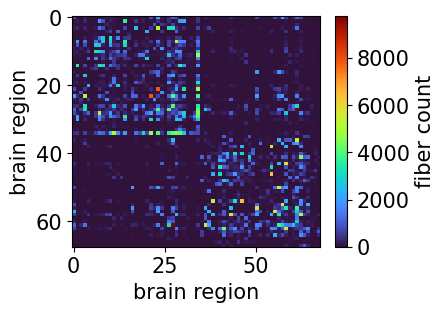

In [7]:
# check brain adjacency matrix

plt.figure(figsize=(4, 3))
plt.imshow(brain_networks.mean(0).reshape(n_rois, n_rois)*count_offset, aspect="auto", cmap="turbo")
plt.xlabel("brain region")
plt.ylabel("brain region")
plt.colorbar(label="fiber count")
plt.show()

In [8]:
# preprocess trait to prevent gradient explosion
# scaler = StandardScaler()
# traits = scaler.fit_transform(traits)
trait_offset = 100.
traits /= traits.max() / trait_offset

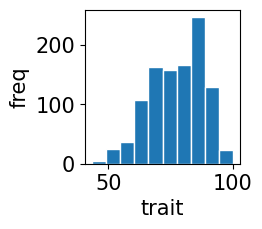

In [9]:
# check trait
plt.figure(figsize=(2,2))
plt.hist(traits, 10, edgecolor='white')
plt.xlabel('trait')
plt.ylabel('freq')
plt.show()

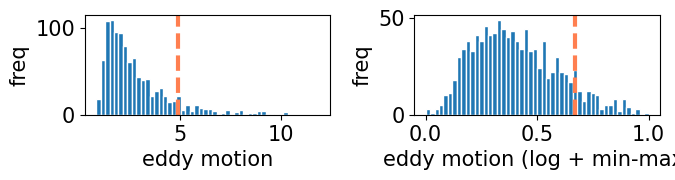

In [10]:
# check motion and rescale motion

norm_motion = min_max_standardize(np.log(motion))

fig, (ax1, ax2) = plt.subplots(1,2,figsize=(7,2))
ax1.hist(motion, 50, edgecolor='white')
ax1.axvline(x=np.quantile(motion, .9), color='coral', ls='dashed', lw=3)
ax1.set_xlabel('eddy motion')
ax1.set_ylabel('freq')
ax2.hist(norm_motion, 50, edgecolor='white')
ax2.axvline(x=np.quantile(norm_motion, .9), color='coral', ls='dashed', lw=3)
ax2.set_xlabel('eddy motion (log + min-max)')
ax2.set_ylabel('freq')
plt.tight_layout()
plt.show()

In [11]:
# mark subjects with big motion for later analysis

sub_ids = np.arange(len(brain_networks)).reshape(-1,1)
big_motion_ids = sub_ids[norm_motion > np.quantile(norm_motion, .9)]
big_motion_mask = np.zeros_like(sub_ids)
big_motion_mask[np.isin(sub_ids, big_motion_ids)] = True
print('num of big motion subjects: {}.'.format(len(big_motion_ids)))

small_motion_ids = sub_ids[norm_motion < np.quantile(norm_motion, .1)]
small_motion_mask = np.zeros_like(sub_ids)
small_motion_mask[np.isin(sub_ids, small_motion_ids)] = True
print('num of small motion subjects: {}.'.format(len(small_motion_ids)))

num of big motion subjects: 106.
num of small motion subjects: 106.


model fitting

In [12]:
# model config

config = Namespace(n_nodes=n_rois, latent_dim=68, hidden_dim=1024, nuisance_dim=0,
    n_enc_layers=1, n_dec_layers=3, n_neighbors=32, drop_out=0.,
    beta = .1, 
    add_reg = True, y_dim = 1, 
    batch_size=32, n_epochs=500, lr=5e-6, weight_decay=0.,
    device=DEVICE)

In [13]:
# prepare torch datasets for training

ids = list(range(n_subs))
random.shuffle(ids)
train_ids = ids[:int(.9*n_subs)]
val_ids = ids[int(.9*n_subs):]
print(len(train_ids), len(val_ids))

tensor_nets = torch.stack([torch.Tensor(i) for i in list(brain_networks)]).to(torch.float32).view(-1, config.n_nodes*config.n_nodes)
tensor_motion = torch.from_numpy(motion).to(torch.float32)
tensor_traits = torch.from_numpy(traits).to(torch.float32) # oral reading recognition score

train_set = utils.TensorDataset(tensor_nets[train_ids], tensor_motion[train_ids], tensor_traits[train_ids] )
val_set = utils.TensorDataset(tensor_nets[val_ids], tensor_motion[val_ids],  tensor_traits[val_ids])

train_loader = utils.DataLoader(train_set, config.batch_size) 
val_loader = utils.DataLoader(val_set, config.batch_size)

954 107


In [14]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

3 torch.Size([68, 68])


VAE

In [15]:
model = VAE(config).to(config.device)
model.apply(reset_weights)
model.set_mask(knn_masks)
optimizer = optim.Adam(model.parameters(), lr=config.lr, weight_decay=config.weight_decay) 

In [16]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = model.reg_train(epoch, train_loader, model, optimizer, config.device, n_epoch_display=5)
    val_loss = model.reg_test(epoch, val_loader, model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

epoch: 0 train loss: 7382.243 nll: 1909.254 kl: 287.530 rmse: 13.069
epoch: 0 test loss: 2632.336 nll: -2150.469 kl: 333.823 rmse: 13.036
epoch: 5 train loss: -15124.013 nll: -16251.016 kl: 4452.872 rmse: 4.605
epoch: 5 test loss: -15723.464 nll: -16730.283 kl: 5135.037 rmse: 4.169
epoch: 10 train loss: -15991.252 nll: -16872.698 kl: 6403.402 rmse: 2.743
epoch: 10 test loss: -16228.623 nll: -17112.303 kl: 6489.991 rmse: 2.863
epoch: 15 train loss: -16059.169 nll: -16916.966 kl: 6254.552 rmse: 2.693
epoch: 15 test loss: -16289.737 nll: -17152.568 kl: 6347.828 rmse: 2.822
epoch: 20 train loss: -16090.881 nll: -16935.551 kl: 6171.431 rmse: 2.665
epoch: 20 test loss: -16320.107 nll: -17171.114 kl: 6266.926 rmse: 2.798
epoch: 25 train loss: -16111.310 nll: -16945.208 kl: 6105.212 rmse: 2.640
epoch: 25 test loss: -16338.682 nll: -17179.914 kl: 6199.807 rmse: 2.779
epoch: 30 train loss: -16127.748 nll: -16951.136 kl: 6039.926 rmse: 2.617
epoch: 30 test loss: -16354.928 nll: -17186.702 kl: 613

In [17]:
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

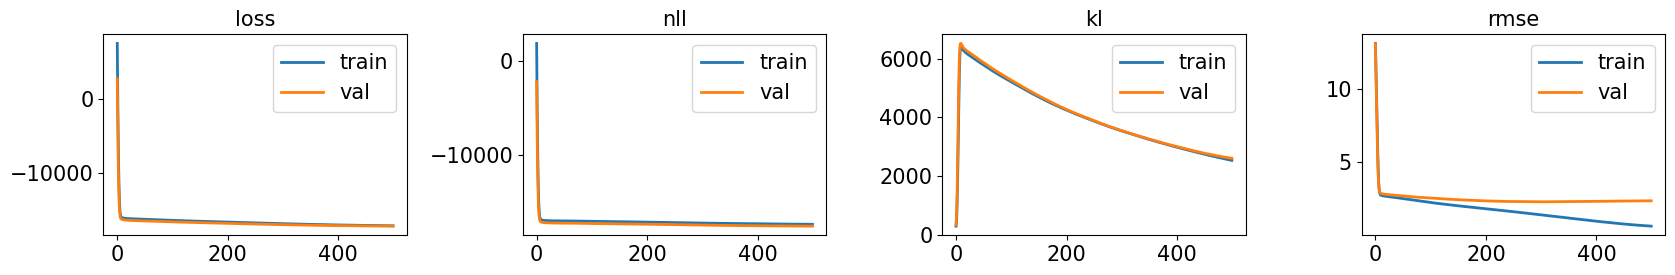

In [18]:
# diagnostics
fig, axes = plt.subplots(1, 4, figsize=(17, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('rmse')
axes[3].legend(loc=1)
plt.tight_layout()
plt.show()

In [19]:
# torch.save(model.state_dict(), './pretrained/abcd_vae_pretrained.mod')
# model.load_state_dict(torch.load('./pretrained/abcd_vae_pretrained.mod'))

In [20]:
z_mean, z_logvar = model.encode(tensor_nets.to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device))
z_sample = model.reparameterize(z_mean, z_logvar)
vae_latents = z_sample.detach().cpu().numpy()

x_recon, y_pred = [], []
with torch.no_grad():
    for i in range(len(tensor_nets)):
        recon, pred, _, _ = model(
            tensor_nets[i].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device)
        )
        x_recon.append(recon.detach().cpu().numpy().reshape(n_rois, n_rois))
        y_pred.append(pred.detach().cpu().numpy())
x_recon = np.array(x_recon)
y_pred = np.array(y_pred).squeeze()

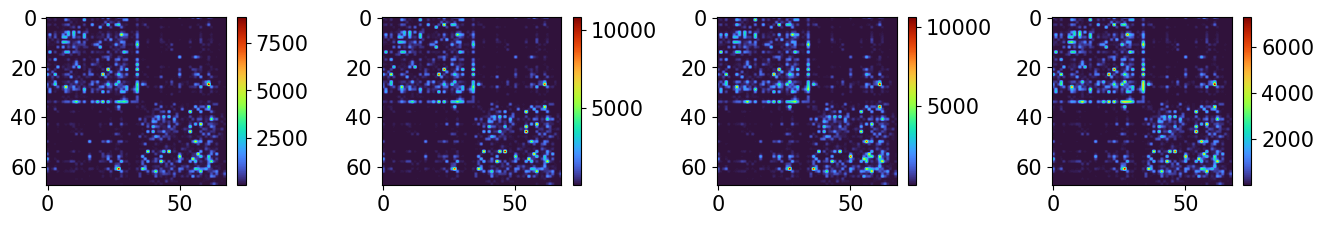

In [21]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_recon[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='turbo')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [22]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_recon = x_recon[big_motion_ids]
small_motion_recon = x_recon[small_motion_ids]
diff_motion_recon= big_motion_recon.mean(0) - small_motion_recon.mean(0)

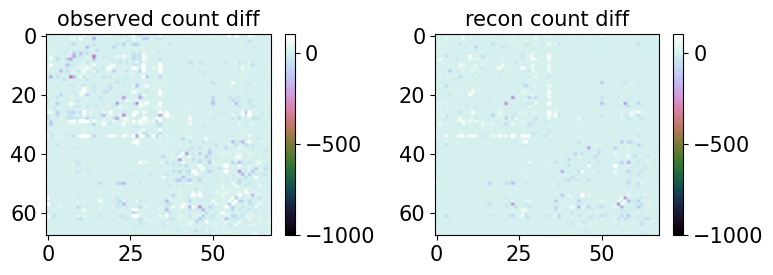

In [23]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_recon.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('recon count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_122078/1821696300.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


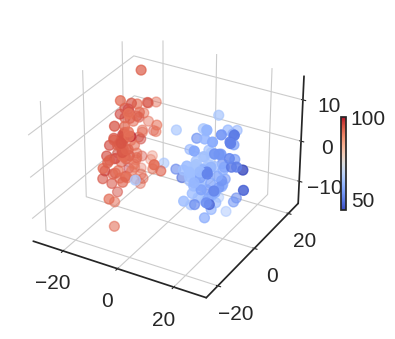

In [24]:
# viz of trait prediction

y_pred = y_pred
y_obs = traits.squeeze()

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy().squeeze()
pca = PCA(n_components=3)
pca.fit(z_mean_sub)
pca_results = pca.transform(z_mean_sub)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'coolwarm', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
# ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
# ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
# ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-25, 25)
ax.set_zlim3d(-15, 15)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [25]:
print(explained_variance_score(y_obs, y_pred))
print(spearmanr(y_obs.flatten(), y_pred.flatten())[0])

0.8350436935050576
0.9227693138755754


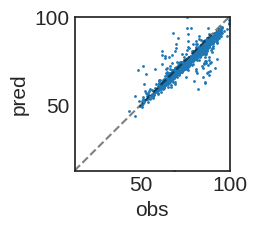

In [26]:
plt.figure(figsize=(2,2))
plt.scatter(y_obs, y_pred, s=1)
plt.xlim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.ylim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.plot([np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         [np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         ls="--", c="k", alpha=.5)
plt.xlabel("obs")
plt.ylabel("pred")
plt.show()

inv-vae

In [27]:
# model config

config = Namespace(
    n_nodes=68, 
    latent_dim=68, 
    hidden_dim=1024, 
    nuisance_dim=1,
    n_enc_layers=1, 
    n_dec_layers=3, 
    n_neighbors=32, 
    drop_out=0., 
    beta = 100, 
    gamma = 0.1, 
    add_reg = True, y_dim = 1, weight_decay=0,
    batch_size=32, n_epochs=500, 
    lr=5e-6, 
    device=DEVICE)

In [28]:
# create masks for graph convolution layers

A_mat = np.mean(brain_networks.reshape(-1,n_rois,n_rois), axis=0)
A_mat = A_mat + A_mat.transpose()
knn_masks = [torch.from_numpy(np.float32(np.argsort(np.argsort(A_mat, axis=-1), axis=-1) < config.n_neighbors+i)).float() for i in range(config.n_dec_layers)]
print(len(knn_masks), knn_masks[0].shape)

3 torch.Size([68, 68])


In [29]:
inv_model = INV_VAE(config).to(config.device)
inv_model.apply(reset_weights)
inv_model.set_mask(knn_masks)
optimizer = optim.Adam(inv_model.parameters(), lr=config.lr, weight_decay=config.weight_decay) 

In [30]:
train_losses = []
val_losses = []
for epoch in range(config.n_epochs):
    train_loss = inv_model.reg_train(epoch, train_loader, inv_model, optimizer, config.device, n_epoch_display=5)
    val_loss = inv_model.reg_test(epoch, val_loader, inv_model, config.device, n_epoch_display=5)
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
train_losses = np.array(train_losses)
val_losses = np.array(val_losses)

epoch: 0 train loss: 6506.413 nll: 2344.040 kl: 357.413 inv_loss: 2.661 rmse: 13.733
epoch: 0 test loss 5727.248 nll: -870.428 kl: 446.131 inv_loss: 1.916 rmse: 14.188
epoch: 5 train loss: 604.623 nll: -14974.181 kl: 13176.298 inv_loss: 1.025 rmse: 7.908
epoch: 5 test loss 186.080 nll: -15769.172 kl: 17705.113 inv_loss: 1.843 rmse: 7.498
epoch: 10 train loss: -1402.938 nll: -16830.919 kl: 14407.571 inv_loss: 0.841 rmse: 2.469
epoch: 10 test loss -1343.970 nll: -17073.817 kl: 15038.244 inv_loss: 1.853 rmse: 2.500
epoch: 15 train loss: -1466.210 nll: -16896.436 kl: 15399.490 inv_loss: 0.752 rmse: 2.144
epoch: 15 test loss -1372.597 nll: -17130.878 kl: 15714.607 inv_loss: 1.789 rmse: 2.395
epoch: 20 train loss: -1477.997 nll: -16921.928 kl: 15490.201 inv_loss: 0.673 rmse: 2.134
epoch: 20 test loss -1383.446 nll: -17155.018 kl: 15798.117 inv_loss: 1.711 rmse: 2.391
epoch: 25 train loss: -1487.409 nll: -16935.071 kl: 15556.625 inv_loss: 0.605 rmse: 2.125
epoch: 25 test loss -1392.140 nll: -

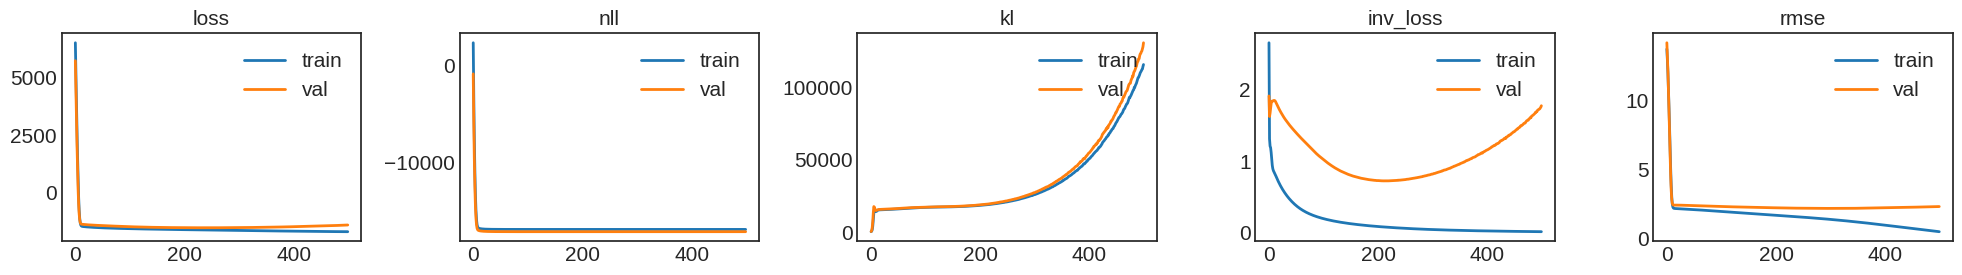

In [31]:
# diagnostics
fig, axes = plt.subplots(1, 5, figsize=(20, 3))
axes[0].plot(train_losses[:,0], linewidth=2, label='train')
axes[0].plot(val_losses[:,0], linewidth=2, label='val')
axes[0].set_title('loss')
axes[0].legend(loc=1)

axes[1].plot(train_losses[:,1], linewidth=2, label='train')
axes[1].plot(val_losses[:,1], linewidth=2, label='val')
axes[1].set_title('nll')
axes[1].legend(loc=1)

axes[2].plot(train_losses[:,2], linewidth=2, label='train')
axes[2].plot(val_losses[:,2], linewidth=2, label='val')
axes[2].set_title('kl')
axes[2].legend(loc=1)

axes[3].plot(train_losses[:,3], linewidth=2, label='train')
axes[3].plot(val_losses[:,3], linewidth=2, label='val')
axes[3].set_title('inv_loss')
axes[3].legend(loc=1)

axes[4].plot(train_losses[:,4], linewidth=2, label='train')
axes[4].plot(val_losses[:,4], linewidth=2, label='val')
axes[4].set_title('rmse')
axes[4].legend(loc=1)

plt.tight_layout()
plt.show()

In [32]:
# torch.save(inv_model.state_dict(), './pretrained/abcd_inv_vae_pretrained.mod')
# inv_model.load_state_dict(torch.load('./pretrained/abcd_inv_vae_pretrained.mod'))

In [33]:
z_mean, z_logvar = inv_model.encode(tensor_nets.to(config.device))
z_sample = inv_model.reparameterize(z_mean, z_logvar)
inv_latents = z_sample.detach().cpu().numpy()

x_denoised, y_pred = [], []
with torch.no_grad():
    for i in range(len(tensor_nets)):
        recon, pred, _, _ = inv_model(
            tensor_nets[i].to(torch.float32).view(-1, config.n_nodes*config.n_nodes).to(config.device),
            tensor_motion.min()*torch.tensor([1.]).to(config.device).reshape(-1,1)
        )
        x_denoised.append(recon.detach().cpu().numpy().reshape(n_rois, n_rois))
        y_pred.append(pred.detach().cpu().numpy())
x_denoised = np.array(x_denoised)
y_pred = np.array(y_pred).squeeze()

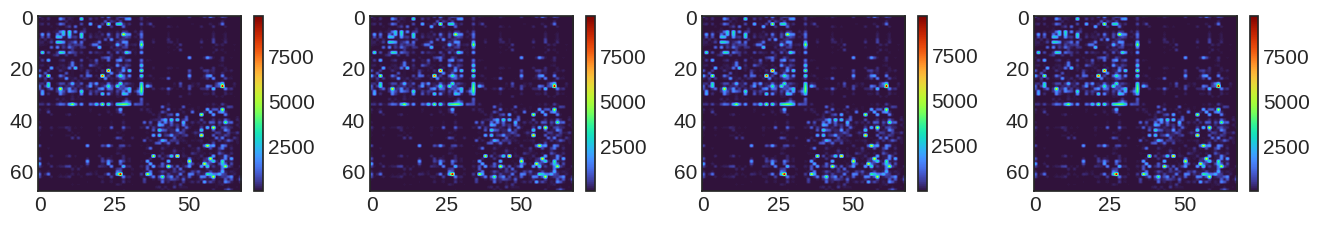

In [34]:
fig, axes = plt.subplots(1, 4, figsize=(13.5, 2.5))
for i, x in enumerate(x_denoised[np.random.choice(ids, 4, replace=False)]):
    p = axes[i].imshow(x*count_offset, aspect='auto', cmap='turbo')
    cbar = plt.colorbar(p, ax=axes[i])
plt.tight_layout()
plt.show()  

In [35]:
big_motion_nets = brain_networks[big_motion_ids]
small_motion_nets = brain_networks[small_motion_ids]
diff_motion_nets = big_motion_nets.mean(0) - small_motion_nets.mean(0)

big_motion_denoised = x_denoised[big_motion_ids]
small_motion_denoised = x_denoised[small_motion_ids]
diff_motion_denoised = big_motion_denoised.mean(0) - small_motion_denoised.mean(0)

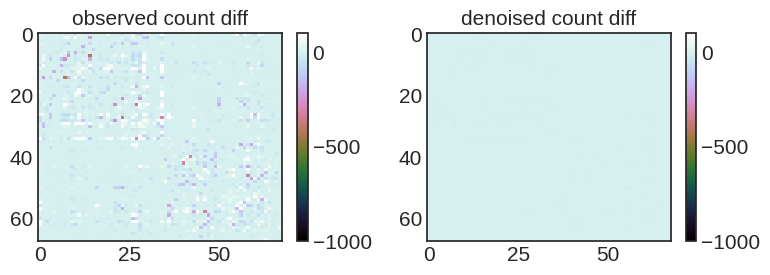

In [36]:
fig, axes = plt.subplots(1,2,figsize=(8,3))

p1=axes[0].imshow(diff_motion_nets.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
p2=axes[1].imshow(diff_motion_denoised.reshape(n_rois,n_rois)*count_offset, aspect='auto', cmap='cubehelix', vmin=-1000, vmax=100)
axes[0].set_title('observed count diff')
axes[1].set_title('denoised count diff')
cbar=plt.colorbar(p1, ax=axes[0])
cbar=plt.colorbar(p2, ax=axes[1])
plt.tight_layout()
plt.show()

/tmp/ipykernel_122078/1821696300.py:16: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


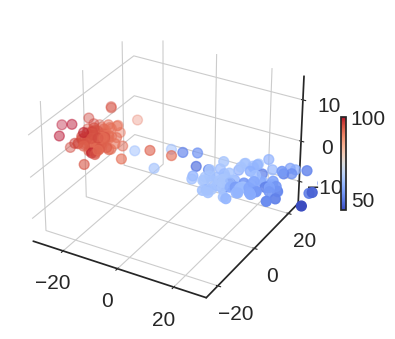

In [37]:
# viz of trait prediction

y_pred = y_pred
y_obs = traits.squeeze()

y_ids = np.argsort(y_obs)
y_sub_ids = np.concatenate([y_ids[:100], y_ids[-100:]])
labels = np.concatenate([np.zeros(100), np.ones(100)])
colors = y_obs[y_sub_ids]

z_mean_sub = z_mean[y_sub_ids, :].detach().cpu().numpy().squeeze()
pca = PCA(n_components=3)
pca.fit(z_mean_sub)
pca_results = pca.transform(z_mean_sub)

plt.style.use('seaborn-white')
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(pca_results[:,0], pca_results[:,1], pca_results[:,2], c=colors, cmap = 'coolwarm', s = 50)
cb = fig.colorbar(p, ax=ax, fraction=0.01)
# ax.set_xlim3d(min(pca_results[:,0]), max(pca_results[:,0]))
# ax.set_ylim3d(min(pca_results[:,1]), max(pca_results[:,1]))
# ax.set_zlim3d(min(pca_results[:,2]), max(pca_results[:,2]))
ax.set_xlim3d(-30, 30)
ax.set_ylim3d(-25, 25)
ax.set_zlim3d(-15, 15)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

In [38]:
print(explained_variance_score(y_obs, y_pred))
print(spearmanr(y_obs.flatten(), y_pred.flatten())[0])

0.8211053487501446
0.9172262435502697


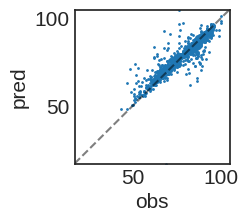

In [39]:
plt.figure(figsize=(2,2))
plt.scatter(y_obs, y_pred, s=1)
plt.xlim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.ylim(np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred])))
plt.plot([np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         [np.min(np.stack([y_obs, y_pred])), np.max(np.stack([y_obs, y_pred]))], 
         ls="--", c="k", alpha=.5)
plt.xlabel("obs")
plt.ylabel("pred")
plt.show()